## Scientific Computing 2022: Homework Assignment 1 
Due Sunday October 16, 2022, 23:59

### Problem 1 (2 points)
Under assumptions of Amdahl's law, suppose that 75% of a program are perfectly parallelizable, and the rest is not parallelizable. 
1. What is the maximum speedup achievable by parallelization? 
2. Suppose that we have obtained speedup 2 (by using a suitable number of processes). What is the efficiency of this parallelization? 

### Solution
1. 
$$
S_p = \frac{1}{\alpha + \frac{1-\alpha}{p}}
$$
$$
1 - \alpha = 0.75 \iff \alpha = 0.25
$$
$$
S_p = \frac{1}{0.25 + \frac{0.75}{p}}
$$
$$
 \lim_{p\to\infty} S_p \ = max(S_p) = \frac{1}{0.25} = 4
$$



2. 
$$
2 = \frac{1}{0.25 + \frac{0.75}{p}}
$$
$$
p = 3
$$
$$
E_p = \frac{S_p}{p} = \frac{2}{3}
$$

### Problem 2 (2 points)
Write a Python or C/C++ program that uses **MPI reduce** to find the largest file in terms of the  number of lines among all .txt files in the working directory (only .txt files should be examined). The program must be callable in the form `mpirun -np <N> python linecount.py` (in the case of the Python version) or `mpirun -np <N> linecount.exe` (the C/C++ version), where `<N>` is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out. The program only needs to output the number of lines in the largest file; no need to output the name of this file. The program must work correctly even if the number of files is not divisible by the number of processes.


### Solution

In [3]:
%%writefile counter.py
from mpi4py import MPI
import os

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

path = os.path.join(os.getcwd(),'data')
files = [file for file in os.listdir(path) if file.endswith('.txt')]

local_max = 0

if size > 1:
    index = rank
else:
    index = 0
    
while index < len(files):
    with open(os.path.join(path, files[index])) as f:
        num = sum(1 for line in f)
    local_max = max(local_max, num)
    index += size
        
result = comm.reduce(local_max, op = MPI.MAX, root = 0)


if rank == 0:
    print ('Max length is equal to', result)

Overwriting counter.py


In [5]:
!mpiexec -np 10 python counter.py

Max length is equal to 10


### Problem 3 (2 points)
Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as $O(f(N))$, where $f(N)$ is some function of the length of the input string). (Note: Sphere may require a VPN connection. If for some reason you cannot use VPN, you can solve a similar problem at the judge DMOJ that does not require VPN: https://dmoj.ca/problem/ccc03s4; note however that this judge does not support numpy. Indicate in your solution which version of the problem you were solving.)

In [3]:
#The problem is taken from spoj.com
import numpy as np

def invPerm(p):
    '''Invert the permutation p'''
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s

def getSA(A):
    if not type(A) is np.ndarray:
        A = np.array(list(A))
    N = len(A) 
    M = int(np.ceil(np.log2(N)))+1   # number of iterations
    
    # auxiliary arrays; row m stores results after m'th step:
    
    # positions of sorted length-(2**m) sequences in A
    P = np.zeros((M,N), dtype=int) 
    
    # rank (0, 1, etc.) of sorted length-(2**m) sequences after sorting
    Q = np.zeros((M,N), dtype=int)     
    
    # rank of sorted length-(2**m) sequences at its starting position in A;
    # padded by 0 on the right
    R = np.zeros((M,3*N), dtype=int) 

    for k in range(M):
        if k == 0:
            P[0] = np.argsort(A)
            Q[0][1:] = np.cumsum(A[P[0]][1:] != A[P[0]][:-1])
            R[0][:N] = Q[0][invPerm(P[0])]
        else:
            offset = 2**(k-1)
            r = np.lexsort((R[k-1, P[k-1]+offset], R[k-1, P[k-1]]))
            P[k] = P[k-1][r]
            # k'th rank increases iff (k-1)'th rank increases at least for one element of the pair    
            Q[k][1:] = np.cumsum(np.logical_or(R[k-1][P[k]][1:] != R[k-1][P[k]][:-1], 
                                          R[k-1][P[k]+offset][1:] != R[k-1][P[k]+offset][:-1]))
            R[k][:N] = Q[k][invPerm(P[k])]
            
            # early stopping if suffixes already fully sorted (max rank is N-1)
            if Q[k][-1] == N-1: 
                break
    
    SA = P[k]
    return  SA, R[:k+1]  

def getLCP(SA, R):
    (M, N) = R.shape
    LCP = np.zeros((len(SA)-1,),dtype=int)
    for m in range(M-1)[::-1]:
        t = (R[m][SA[1:]+LCP] == R[m][SA[:-1]+LCP]).astype(int)
        LCP += (2**m)*t
    return LCP

def main():
    N = int(input())
    test_set = list()
    for i in range(N):
        A = str(input()) + '$'
        test_set.append(A)
    for j in range(N):
        A = test_set[j]
        SA,R = getSA(A)
        LCP = getLCP(SA, R)
        L = len(A)
        S = (2*1+1*(L-1))/2*L
        result = S - sum(LCP)-L
        print(int(result))

if __name__ == '__main__':
    main()



2
banana
ananas
15
15


1. In the first step SA and LCP are computed using the functions defined at the seminar
2. The main idea of the code is to enumerate the prefixes of each suffix of a string. As a result, all substring of that string will be covered.
3. To do this, we simply calculate the length of all suffixes, which is equal to the sum of the arithmetic progression of the first terms {len(string)} in steps of 1 or the sum of SA. Then we subtract the sum of LCP. Finally, not to forget the dollar sign, we have to subtract the sum of its occurrences equal to the length of the string.
4. The complexity of the algorithm is 
$O(Nlog^2N)$

### Problem 4 (2 points)
Suppose that we want to distribute $N$ personal projects to $N$ students. Assume that each student $(k)_{k=0}^{N-1}$ has a list of his/her preferences for the projects, expressed as a vector $\mathbf r_k$ of integer ranks assigned to each project. Ranks vary between 0 and $N-1$ without repetitions, the **lower** the rank the **more preferable** the project. (For example, the first student's ranks are $\mathbf r_0 = [2,1,0]$, the second's $\mathbf r_1 = [0,2,1]$ and the third $\mathbf r_2 = [0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if $n_k$ denotes the project assigned to the $k$'th student, we want to make $f = \sum_{k=0}^{N-1} \mathbf r_k[n_k]$ as small as possible. (In the example above the optimal distribution is $n_0=2, n_1=0, n_2=1$, which gives $f=1$).  
  * Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution $(n_k)_{k=1}^N$. The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for $N=30$. 
  * Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform $M=1000$ experiments in each of which 1) random preference vectors for $N=30$ students and projects are generated; 2) the objective function $f$ is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained $M$ values of $f$ and compute the mean values of $f$ for both algorithms. 

In [4]:
import numpy as np
from copy import deepcopy

def distribution(students):
    '''
    students - np.ndarray of shape (N,N), each row of array is a student's vector
    '''
    N = len(students)
    distr = dict() # keys in dict is project number, values is a list [x,y], where x is student number, y is preference
    stud = deepcopy(students)
    for student in range(N):
        project = np.argmin(stud[student:])
        if project in distr.keys():
            while project in distr.keys():
                stud[student,project] = np.max(stud[student:]) + 1
                project = np.argmin(stud[student,:])
            distr[project] = [student,stud[student,project]]
        else:
            distr[project] = [student,stud[student,project]]
    return distr

def rand_distribution(students):
    N = len(students)
    distr = dict() # keys in dict is project number, values is a list [x,y], where x is student number, y is preference
    stud = deepcopy(students)
    index = np.random.permutation(N)
    for student in range(N):
        distr[index[student]] = [student,stud[student,index[student]]]
    return distr

def f(dictionary):
    res = 0 
    for key in dictionary.keys():
        res += dictionary[key][1]
    return res


In [5]:
N = 30
M = 1000
ar = np.empty((N,N))
mat = dict()
for j in range(M):
    for i in range(N):
        ar[i:] = np.random.permutation(N)
    mat[j] = ar
    ar = np.empty((N,N))

In [6]:
%%time
res_algo = list()
res_rand = list()

for i in range(M):
    res_algo.append(f(distribution(mat[i])))
    res_rand.append(f(rand_distribution(mat[i])))
    
print('Algo_Mean: ', np.mean(res_algo))
print('Rand_Mean: ',np.mean(res_rand))
print()

Algo_Mean:  64.36
Rand_Mean:  434.683

CPU times: total: 1.23 s
Wall time: 1.59 s


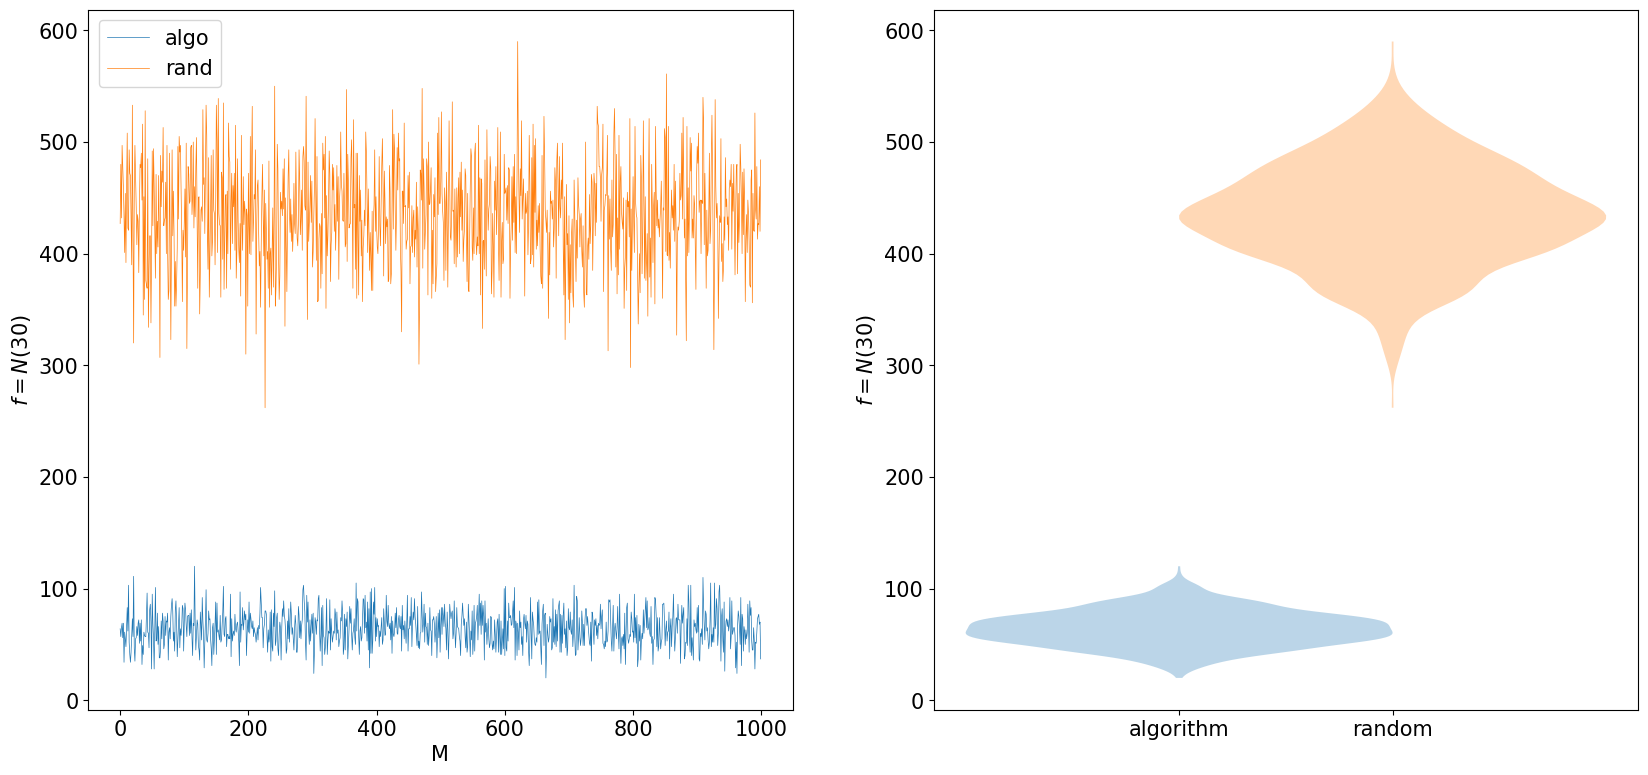

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20,20))
ax1 = figure.add_subplot(2,2,1)
ax2 = figure.add_subplot(2,2,2)

ax1.plot(np.arange(M),res_algo, linewidth = 0.5, label='algo')
ax1.plot(np.arange(M), res_rand, linewidth = 0.5, label='rand')

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(15)
ax1.legend(loc = 'upper left', fontsize = 15)
ax1.set_xlabel('M',fontsize = 15)
ax1.set_ylabel(f'$f=N({N}$)',fontsize = 15)

vp_algo = ax2.violinplot(res_algo, [1], widths=2,
                   showmeans=False, showmedians=False, showextrema=False)
vp_rand = ax2.violinplot(res_rand, [2], widths=2,
                   showmeans=False, showmedians=False, showextrema=False)

labels = ['algorithm', 'random']
ax2.set_xticks(np.arange(1, len(labels) + 1), labels=labels,fontsize = 15)
ax2.set_ylabel(f'$f=N({N}$)',fontsize = 15)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(15)






  
### Problem 5 (2 points)
Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval $[0,1]$. To test our algorithm, we perform a series of experiments. In each experiment, we generate $N=10^3$ numbers $(x_n)_{n=1}^N$ with our algorithm, and compute the minimum distance $r=\min_{1 \le n < m\le N}|x_n-x_m|$ between them. We observe that in more than 99% of such experiments we obtain $r < 10^{-5}$. Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.

## Solution
Since in 99% experiments for $n = 10^3$ $r<10^{-5}$ was obtained we can say that the $E_{exp}[r]<10^{-5}$ 

Let's take a look at segment [0,1]. Consider a random dot $q$ somwhere at the segment. For a fixed $r>0$ let $L_r^{(q)} = \bigl\{x: |x-q| < r\bigl\}$ denote the segment of length $2r$ and define $N_r^{(q)} = \bigl\{x_i: x_i \in L_r^{(q)}\bigl\}$ the number of the random points that fall inside that segment $L_r^{(q)}$.

The probability that random given point will fall inside the segment is equal to $$P[x_i \in D_r^{(q)}] = \frac{length(L_r^{(q)})}{length([0,1])} = \frac{2r}{1} = 2r, r<\frac{1}{2}$$

As a result it follows that for small $r, N_r^{(q)}$ follows a binominal distribution with the probability of success is equal to $2r$, as long as $r<\frac{1}{2}$

Now let's look at variable $M_n^{(q)}$: $$M_n^{(q)} = \min_{i=1,...,n} \bigl\{|x_i-q|\bigl\}$$

It is easy to see that $$P[M_n^{(q)}\leq r] = P[N_r^{(q)}>0]$$
It means that there is a point within a distance $r$ of $q$ ($M_n^{(q)}\leq r$), if there is at least one point inside the $L_r^{(q)}$, so the $N_r^{(q)}>0$

As a result we can obtain the following:
$$P[M_n^{(q)}\leq r] = P[Bin(n, 2r)>0] = 1 - (1-2r)^n$$
To obtain a probability density function let's derive the obtained equation: $$f_n^{(q)}(r) = \frac{d}{dr}P[M_n^{(q)}\leq r] = 2n(1-2r)^{n-1}$$

So the $E[M_n^{(q)}]$ is equal to: $$E[M_n^{(q)}] =  \int_{0}^{\frac{1}{2}} 2rn(1-2r)^{n-1} \,dr $$
Computing the integral under assumtion $n=10^3$ gives us $E[M_n^{(q)}] = 0.0004995 \approx 5*10^{-4}$

Comparing experimental expectated values with the theoretical $E_{exp}[r]<E[M_n^{(q)}]$ we can say that the assumed observation contradict the hypothesis of generating independent uniformly distributed random numbers